# Simulating real-time fMRI classification

In [338]:
#from delphi.networks.ConvNets import BrainStateClassifier3d
import nibabel as nib
import glob
import numpy as np
import os
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.plots import classification_timecourse, confusion_matrix
from delphi.utils.tools import z_transform, compute_accuracy
import torch
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.patches as mpatches

In [367]:
#volume_model_path = "../04_volumetric_approach/models/vol-multitask-classifier-withrest_fold-00"
volume_model_path = "../04_volumetric_approach/models/vol-motor-classifier-withrest_fold-09"
#volume_model_path = "../04_volumetric_approach/models/vol-wm-classifier-withrest_fold-02"

t_model_path = "../transfer_learning/models/from-scratch/motor_samplesize-120_seed-1224_fold-05"

t_model = BrainStateClassifier3d(t_model_path)
t_model.eval();

volume_model = BrainStateClassifier3d(volume_model_path)
volume_model.eval();

Loading from config file ../transfer_learning/models/from-scratch/motor_samplesize-120_seed-1224_fold-05/config.yaml
Loading from config file ../04_volumetric_approach/models/vol-motor-classifier-withrest_fold-09/config.yaml


In [368]:
TASKID = "MOTOR"
PE = "LR" # RL

ev_files = sorted(glob.glob(os.path.join(f"/media/philippseidel/5tb/hcp_download/{TASKID}/logs/*_{PE}.txt")))
ev_files

['/media/philippseidel/5tb/hcp_download/MOTOR/logs/footleft_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/footright_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/handleft_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/handright_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/tongue_LR.txt']

In [369]:
labels = [model.config["class_labels"][i].lower() for i in range(len(model.config["class_labels"]))]

if TASKID == "WM":
    labels_of_interest = sorted(["body", "face", "place", "tool", f"rest_{TASKID.lower()}"])
if TASKID == "MOTOR":
    labels_of_interest = sorted(["handleft", "handright", "footright", "footleft", "tongue", f"rest_{TASKID.lower()}"])
if TASKID == "SOCIAL":
    labels_of_interest = sorted(["mental", "rnd", f"rest_{TASKID.lower()}"])
if TASKID == "RELATIONAL":
    labels_of_interest = sorted(["match", "relation", f"rest_{TASKID.lower()}"])
indices = [i for i, lbl in enumerate(labels) if lbl in labels_of_interest]
indices

[0, 1, 2, 3, 4, 5]

In [370]:
test_sub_fnames = glob.glob("../t-maps/test/body/sub*.nii.gz")
test_subs = [os.path.split(test_subs[i])[1][:9] for i in range(len(test_sub_fnames))]

In [372]:
for s, sub in tqdm(enumerate(test_subs), desc="testsubs"):
    path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    # load the data
    data = nib.load(path2nifti).get_fdata()
    data = np.nan_to_num(z_transform(data))
    
    data = torch.tensor(data)
    
    if s == 0:
        predicted_volume = np.zeros((data.size()[-1], len(test_subs)))
        predicted_t = np.zeros_like(predicted_volume)
        
        probs_volume = np.zeros((data.size()[-1], volume_model.config["n_classes"], len(test_subs)))
        probs_t = np.zeros((data.size()[-1], t_model.config["n_classes"], len(test_subs)))
        
    for i in tqdm(range(data.size()[-1]), desc="volumes"):
        in_vol = data[:,:,:,i].unsqueeze(0).unsqueeze(0)

        # get the predictions for the model trained on volumes
        out = volume_model.SM(volume_model(in_vol.float()))
        probs_volume[i,:,s] = out.detach().cpu().numpy()
        predicted_volume[i,s] = np.argmax(probs_volume[i,:, s])
        
        # get the predictions for the model trained on t-maps
        out = t_model.SM(t_model(in_vol.float()))
        probs_t[i,:,s] = out.detach().cpu().numpy()
        predicted_t[i,s] = np.argmax(probs_t[i,:, s])        

testsubs: 0it [00:00, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

### generate the volume wise real labels

In [411]:
real = np.zeros(data.shape[-1])
bold_lag = 5

ctr = 0
for i, ax in enumerate(labels_of_interest):
    if "rest" in labels_of_interest[i]:
        pass
    else:
        onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
        for j, on in enumerate(onset[0].values):
            real[int(on+bold_lag):int(on+onset[1].values[0]+bold_lag)] = indices[i]+1
    
        ctr+=1

real[real==0] = np.squeeze(np.where(np.array(f"rest_{TASKID.lower()}") == np.array(labels)))+1
real = real-1

In [412]:
real

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 4., 4., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4.,
       4., 4., 4., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 4.,
       4., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

### compute the accuracy for each subject

In [413]:
accs = np.zeros((len(test_subs), 2))

for i in range(len(test_subs)):
    accs[i, 0] = compute_accuracy(real, predicted_volume[:, i])
    accs[i, 1] = compute_accuracy(real, predicted_t[:, i])

accs

array([[0.75704225, 0.42253521],
       [0.81338028, 0.54577465],
       [0.69366197, 0.43309859],
       [0.66549296, 0.39084507],
       [0.82394366, 0.53169014],
       [0.70070423, 0.49647887],
       [0.67605634, 0.38732394],
       [0.82042254, 0.5       ],
       [0.77464789, 0.45070423],
       [0.70070423, 0.41549296],
       [0.66549296, 0.41197183],
       [0.65492958, 0.44366197],
       [0.6584507 , 0.39084507],
       [0.75704225, 0.50704225],
       [0.63732394, 0.42605634],
       [0.71126761, 0.53873239],
       [0.68309859, 0.52816901],
       [0.66901408, 0.38380282],
       [0.78521127, 0.57746479],
       [0.62676056, 0.47535211]])

In [422]:
predicted_volume_cropped

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4., 4., 4., 4., 4., 1.,
       2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 3., 0., 0., 2., 2.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 0., 5.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 3., 5., 3., 3., 3.,
       2., 0., 2., 2., 0., 2., 2., 0., 2., 2., 2., 0., 2., 2., 2., 2., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 4., 4., 4.])

In [423]:
# let's be more fair for the t-map trained NN and remove the rest parts
accs2 = np.zeros_like(accs)

real_cropped = real
real_cropped = np.delete(real_cropped, np.where(real==4))

for i in range(len(test_subs)):
    predicted_volume_cropped = predicted_volume[:, i]
    predicted_volume_cropped = np.delete(predicted_volume_cropped, np.where(real==4))
    predicted_t_cropped = predicted_t[:, i]
    predicted_t_cropped = np.delete(predicted_t_cropped, np.where(real==4))
    
    accs2[i, 0] = compute_accuracy(real_cropped, predicted_volume_cropped)
    accs2[i, 1] = compute_accuracy(real_cropped, predicted_t_cropped)

accs2

array([[0.84117647, 0.63529412],
       [0.93529412, 0.78823529],
       [0.76470588, 0.51176471],
       [0.65294118, 0.55294118],
       [0.93529412, 0.74117647],
       [0.8       , 0.67058824],
       [0.77647059, 0.58235294],
       [0.96470588, 0.73529412],
       [0.9       , 0.68823529],
       [0.73529412, 0.52352941],
       [0.8       , 0.62941176],
       [0.63529412, 0.61764706],
       [0.71176471, 0.53529412],
       [0.87058824, 0.7       ],
       [0.74705882, 0.58235294],
       [0.78823529, 0.71176471],
       [0.65294118, 0.64705882],
       [0.65294118, 0.55882353],
       [0.85882353, 0.71764706],
       [0.70588235, 0.68823529]])

In [364]:
print(f"Across subjects average classification accuracy over whole-time course for {TASKID} task:", accs.mean(), "+/-", accs.std()/np.sqrt(len(test_subs)), "(s.e.m)")

Across subjects average classification accuracy over whole-time course for MOTOR task: 0.7137323943661972 +/- 0.013757425723845054 (s.e.m)


### conf-mat across all subjects

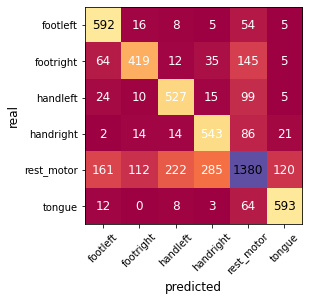

In [365]:
real_vec = np.tile(real, len(test_subs))
pred_vec = predicted.flatten('F')

fig, ax = plt.subplots()
mat, _ = confusion_matrix(real_vec, pred_vec, model.config["class_labels"], ax=ax)

### show some classification time-course (average across all test-subjects)

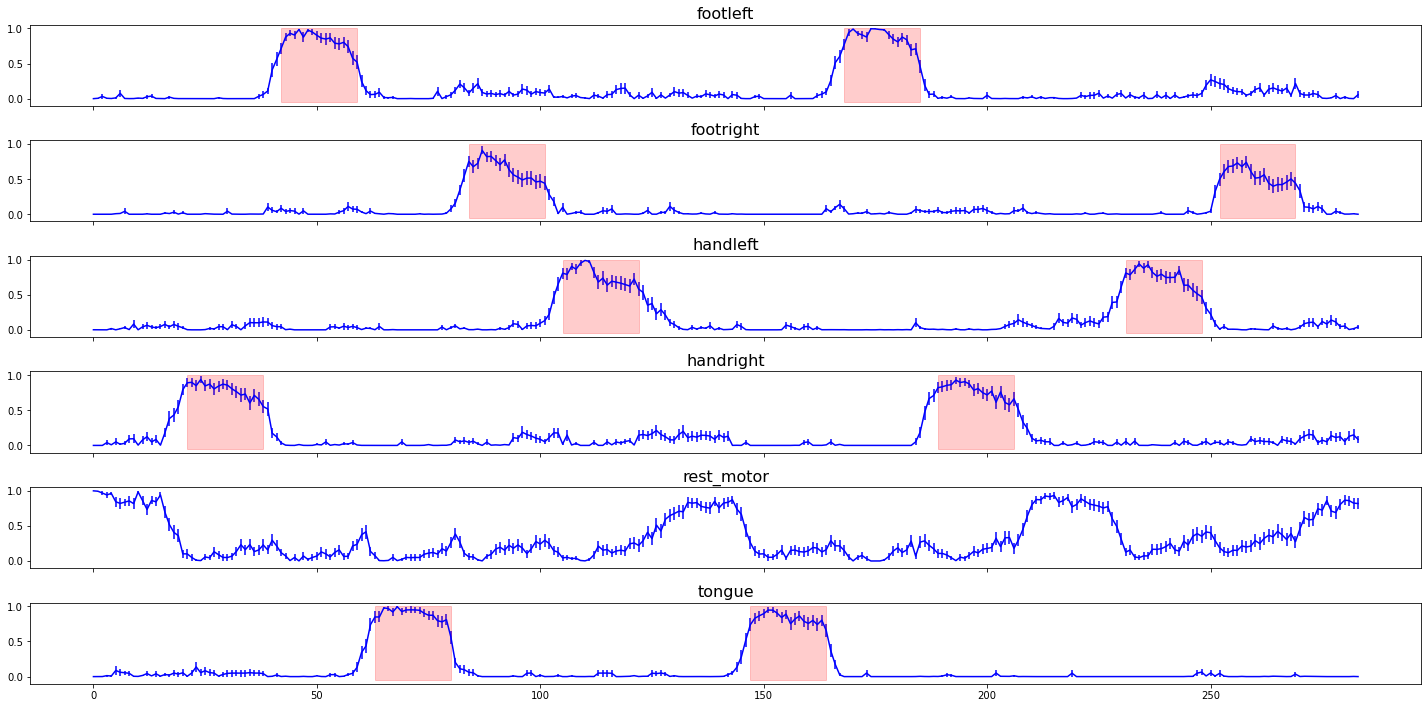

In [366]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(labels_of_interest),1, figsize=(20,10), sharex=True, sharey=True)

x = np.arange(len(predicted))*.72

# the HRF peaks at about 4-6 seconds after the stimulus onset.
bold_lag = 5

mu = probs.mean(axis=2)
sem = probs.std(axis=2)/np.sqrt(len(test_subs))

ctr = 0
for i, ax in enumerate(axes):
    #ax.plot(predicted==indices[i], linewidth=2)
    ax.errorbar(np.arange(len(mu)), mu[:, i], sem[:,i], color='blue', zorder=1)
    if "rest" in labels_of_interest[i]:
        pass
    else:
        onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
        for j, on in enumerate(onset[0].values):
            rect=mpatches.Rectangle((on+bold_lag, -.05),onset[1].values[0], 1.05, 
                        fill = True, alpha=.2,
                        color = "red",
                        linewidth = 1)
            ax.add_patch(rect)
            #ax.axvline(on+bold_lag, color='r')
            #ax.axvline(on+onset[1].values[0]+bold_lag, color='r', linestyle="--")
        ctr+=1
    ax.set_title(labels_of_interest[i])

fig.tight_layout()

In [410]:
ax.get_ylim()[0]

-0.10250000000000001